# MATH50003 Numerical Analysis: Problem Sheet 6

This problem sheet explores condition numbers, indefinite integration,
and Euler's method.

Questions marked with a ⋆ are meant to be completed without using a computer.

In [2]:
using LinearAlgebra, Plots

## 1. Condition numbers


**Problem 1.1⋆** Prove that, if $|ϵ_i| ≤ ϵ$ and $n ϵ < 1$, then
$$
\prod_{k=1}^n (1+ϵ_i) = 1+θ_n
$$
for some constant $θ_n$ satisfying $|θ_n| ≤ {n ϵ \over 1-nϵ}$.

**Problem 1.2⋆** Let $A,B ∈ ℝ^{m × n}$. Prove that if the columns satisfy $\|𝐚_j\|_2 ≤ \| 𝐛_j\|_2$ then
$\|A\|_F ≤ \|B\|_F$ and $\|A \|_2 ≤ \sqrt{\hbox{rank}(B)} \|B\|_2$.

**Problem 1.3⋆** Compute the 1-norm, 2-norm, and ∞-norm condition numbers for the following matrices:
$$
\begin{bmatrix}
1 & 2 \\ 3 & 4
\end{bmatrix}, \begin{bmatrix}
1/3 & 1/5 \\ 0 & 1/7
\end{bmatrix}, \begin{bmatrix} 1 \\ & 1/2 \\ && ⋯ \\ &&& 1/2^n \end{bmatrix}
$$
(Hint: recall that the singular values of a matrix $A$ are the square roots of the eigenvalues of the Gram matrix
$A^⊤A$.)


**Problem 1.4**
State a bound on the relative error on $A 𝐯$ for $\|𝐯\|_2 = 1$ for the following matrices:
$$
\begin{bmatrix}
1/3 & 1/5 \\ 0 & 1/10^3
\end{bmatrix},
 \begin{bmatrix} 1 \\ & 1/2 \\ && ⋯ \\ &&& 1/2^{10} \end{bmatrix}
$$
Compute the relative error in computing $A 𝐯$ (using `big` for a high-precision version to compare against)
where $𝐯$ is the last column of $V$ in the SVD $A = U Σ V^⊤$, computed using the `svd` command with
`Float64` inputs. How does the error compare to the predicted error bound?





## 2. Indefinite integration

**Problem 2.1** Implement backward differences to approximate
indefinite-integration. How does the error compare to forward
and mid-point versions  for $f(x) = \cos x$ on the interval $[0,1]$?
Use the method to approximate the integrals of
$$
\exp(\exp x \cos x + \sin x), \prod_{k=1}^{1000} \left({x \over k}-1\right), \hbox{ and } f^{\rm s}_{1000}(x)
$$
to 3 digits, where $f^{\rm s}_{1000}(x)$ was defined in PS2.


**Problem 2.2** Implement indefinite-integration 
where we take the average of the two grid points:
$$
{u'(x_{k+1}) + u'(x_k) \over 2} ≈ {u_{k+1} - u_k \over h}
$$
What is the observed rate-of-convergence using the ∞-norm for $f(x) = \cos x$
on the interval $[0,1]$?
Does the method converge if the error is measured in the $1$-norm?

### 2.1

In [25]:
function backindefint(f, c, n=50)
    x = range(0, 1; length=n)
    h = step(x)
    n = length(x)
    d = [1; fill(1/h, n-1)]
    ld = fill(-1/h, n-1)
    L = Bidiagonal(d, ld, :L)

    f = [c; f.(x[2:end])]
    u = L \ f
    x, u
end

#NOTE: might break if x defined inside the function then try to plot x in scatter

backindefint (generic function with 3 methods)

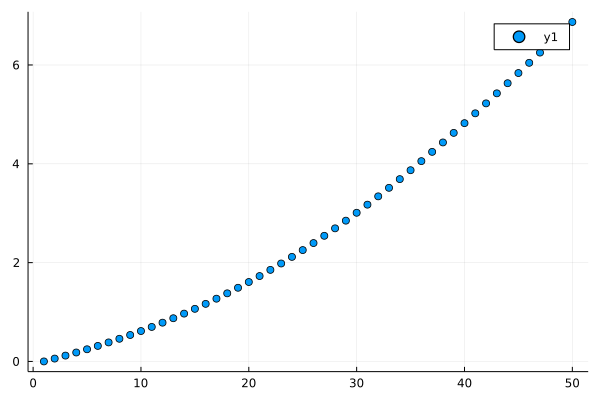

In [30]:
function a1(x)
    exp(exp(x)cos(x)+sin(x))
end

u1 = backindefint(a1, 0)
scatter(u1)

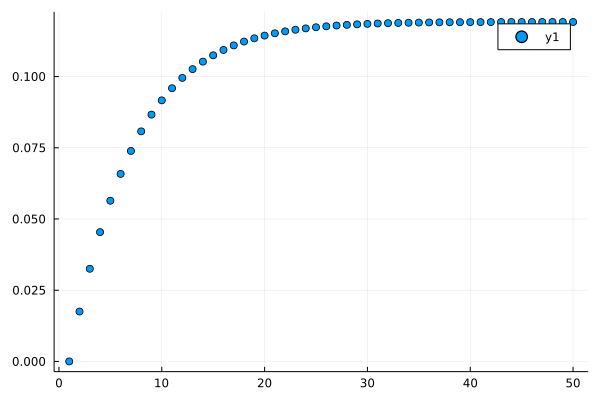

In [31]:
function a2(x)
    ret = x - 1
    for k = 2:1000
        ret = ret*(x/k - 1)
    end
    ret
end

u2 = backindefint(a2, 0)
scatter(u2)

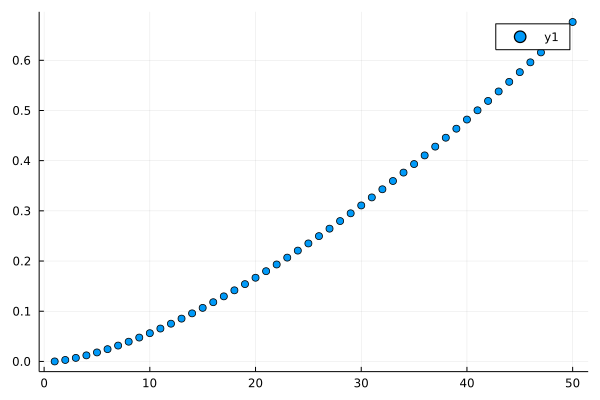

In [32]:
function a3(x,s=1000)
    if s == 1
        1 + (x - 1)/2
    else
        1 + (x - 1)/(1 + a3(x,s-1))
    end
end

u3 = backindefint(a3, 0)
scatter(u3)

### 2.2

In [33]:
function midindefint(f, c, n=50)
    x = range(0, 1; length=n)
    m = (x[1:end-1] - x[2:end]) / 2
    h = step(x)
    n = length(x)

    d = [1; fill(1/h, n-1)]
    ld = fill(-1/h, n-1)
    L = Bidiagonal(d, ld, :L)

    f = [c; f.(m)]
    u = L \ f
    x, u
end

midindefint (generic function with 2 methods)

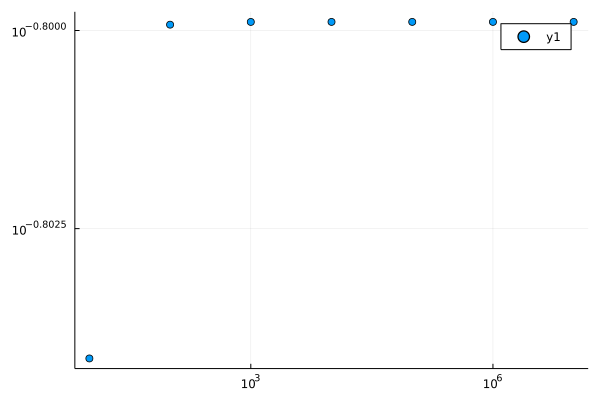

In [49]:
#test on cos(x)
function mid_error(u, c ,f, n)
    # where u'(x) = f(x), u(0) = c
    x, u_mid = midindefint(f, c, n)
    norm(u_mid - u.(x), Inf)
end

ns = 10 .^ (1:7)

scatter(ns, mid_error.(sin, 0, cos, ns); yscale=:log10, xscale=:log10) #error converges?

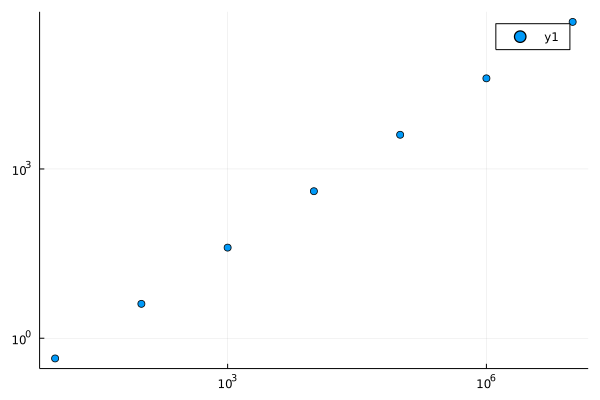

In [50]:
function mid_error_1(u, c ,f, n)
    # where u'(x) = f(x), u(0) = c
    x, u_mid = midindefint(f, c, n)
    norm(u_mid - u.(x), 1)
end

ns = 10 .^ (1:7)

scatter(ns, mid_error_1.(sin, 0, cos, ns); yscale=:log10, xscale=:log10) #error diverges in 1 norm

## 3. Euler methods

**Problem 3.1** Solve the following ODEs 
using forward and/or backward Euler and increasing $n$, the number of time-steps, 
until $u(1)$ is determined to 3 digits:
$$
\begin{align*}
u(0) &= 1, u'(t) = \cos(t) u(t) + t \\
v(0) &= 1, v'(0) = 0, v''(t) = \cos(t) v(t) + t \\
w(0) &= 1, w'(0) = 0, w''(t) = t w(t) + 2 w(t)^2
\end{align*}
$$
If we increase the initial condition $w(0) = c > 1$, $w'(0)$
the solution may blow up in finite time. Find the smallest positive integer $c$
such that the numerical approximation suggests the equation
does not blow up.

In [60]:
n = 100
t = range(0, 1; length=n)
h = step(t)

U = zeros(n) # store u_k's as a vector
U[1] = 1 # initial condition u_1 = 1
for k = 1:n-1 # forward euler
    U[k+1] = (1 + h*cos(t[k]))*(U[k] + h*t[k])
end
u_1 = U[n]

A = t -> [0 1; cos(t) 0]
V = zeros(2,n)
V[:,1] = [1.0, 0.0]
for k = 1:n-1
    V[:,k+1] = (I + h*A(t[k]))*V[:,k] + h*[0; t[k]]
end
v_1 = V[1,n]

W = zeros(2,n)
W[:,1] = [1.0, 0.0]
for k = 1: n-1
    W[:,k+1] = W[:,k] + h*[W[2,k], t[k]*W[1,k] + 2*(W[1,k])^2]
end
w_1 = W[1,n]

[u_1, v_1, w_1]

3-element Vector{Float64}:
 2.9590967981888197
 1.6555154283701876
 2.7244857353781673

**Problem 3.2⋆** For an evenly spaced grid $t_1, …, t_n$, use the approximation
$$
{u'(t_{k+1}) + u'(t_k) \over 2} ≈ {u_{k+1} - u_k \over h}
$$
to recast
$$
\begin{align*}
u(0) &= c \\
u'(t) &= a(t) u(t) + f(t)
\end{align*}
$$
as a lower bidiagonal linear system. Use forward-substitution to extend this to vector linear problems:
$$
\begin{align*}
𝐮(0) &= 𝐜 \\
𝐮'(t) &= A(t) 𝐮(t) + 𝐟(t)
\end{align*}
$$


**Problem 3.3** Implement the method designed in Problem 3.1 for the negative time Airy equation 
$$
u(0) = 1, u'(0) = 0, u''(t) = -t u(t)
$$
on $[0,50]$.
How many time-steps are needed to get convergence to 1% accuracy (the "eyeball norm")?

**Problem 3.4** Implement Heat on a graph with $m = 50$ nodes with no forcing
and initial condition $u_{m/2}(0) = 1$ and $u_k(0) = 0$, but where the first and last node are fixed
to  zero, that is replace the first and last rows of the differential equation with
the conditions:
$$
u_1(t) = u_m(t) = 0.
$$
Find the time $t$ such that  $\|𝐮(t)\|_∞ <10^{-3}$ to 2 digits.
Hint: Differentiate to recast the conditions as a differential equation.
Vary $n$, the number of time-steps used in Forward Euler, and increase $T$ in the interval $[0,T]$
until the answer doesn't change.
Do a for loop over the time-slices to find the first that satisfies the condition.
(You may wish to call `println` to print the answer and `break` to exit the for loop).


### 3.3

In [61]:
n = 100_000
t = range(0, 50; length=n)
A = t -> [0 1; -t 0]
h = step(t)

U = zeros(2, n) # each column is a time-slice
U[:,1] = [1.0,0.0] # initial condition
for k = 1:n-1
    U[:,k+1] = (I + h*A(t[k]))*U[:,k]
end

### 3.4

**Problem 3.5** Consider the equation
$$
u(1) = 1, u'(t) = -10u(t)
$$
What behaviour do you observe on $[0,10]$ of forward, backward, and that of Problem 3.1
with a step-size of 0.5? What happens if you decrease the step-size to $0.01$? (Hint: you may wish to do a plot and scale the $y$-axis logarithmically,)

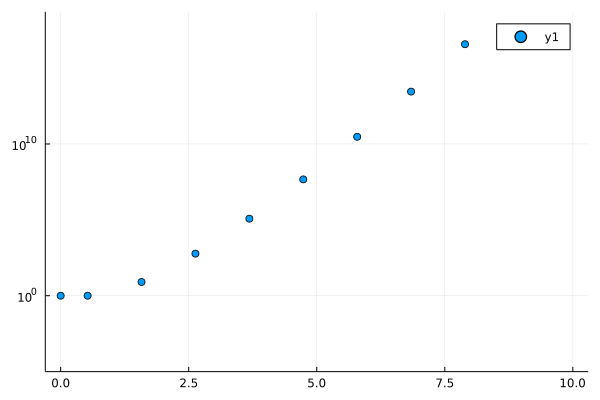

┌ Warning: Invalid negative or zero value -1.7700831024930745 found at series index 3 for log10 based yscale
└ @ Plots C:\Users\willi\.julia\packages\Plots\9C6z9\src\utils.jl:95


In [93]:
# euler methods for u'(t) = a(t)u(t) + g(t)
function forward_euler(a, f, c, n=20)
    t = range(0, 10, length=n)
    h = step(t)
    u = zeros(n)
    u[1] = c
    for k = 1:n-1
        u[k+1] = (1 + h*a(t[k]))*u[k] + h*f(t[k])
    end
    t, u
end

function backward_euler(a, f, c, n=20)
    t = range(0, 10, length=n)
    h = step(t)
    u = zeros(n)
    u[1] = c
    for k = 2:n
        u[k+1] = (u[k] + h*f(t[k+1])) / (1 - h*a(t[k+1]))
    end
    t, u
end

function midpoint(a, f, c, n=20)
    t = range(0, 10, length=n)
    m = (t[1:end-1] - t[2:end]) / 2
    h = step(t)
    u = zeros(n)
    u[1] = c
    for k = 1:n-1
        u[k+1] = u[k] # not sure if to do triple mk, mk-1 mk+1 relation or not
    end
    t, u
end

a = t -> -10t
f = t -> 0

scatter(forward_euler(a, f, 1); ylims = (10^-5,10^30), yscale=:log10)